<a href="https://colab.research.google.com/github/foadsadr/House_prediction_tehran/blob/main/Converting_Points_to_Polygons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install geopandas shapely matplotlib

In [2]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from scipy.stats import zscore
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
import re
import requests
import xml.etree.ElementTree as ET

In [3]:
drive.mount('/content/drive')
df_region = pd.read_csv('/content/drive/My Drive/regions_updated.csv')


Mounted at /content/drive


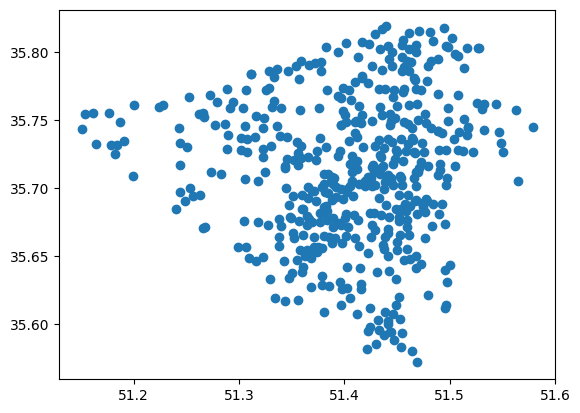

In [4]:
plt.scatter(df_region['longitude'], df_region['latitude'])
plt.show()

In [5]:
# Filter only points within a reasonable Tehran range
df_filtered = df_region[
    (df_region['longitude'] > 50) & (df_region['longitude'] < 52.5) &
    (df_region['latitude'] > 35.3) & (df_region['latitude'] < 35.9)
]

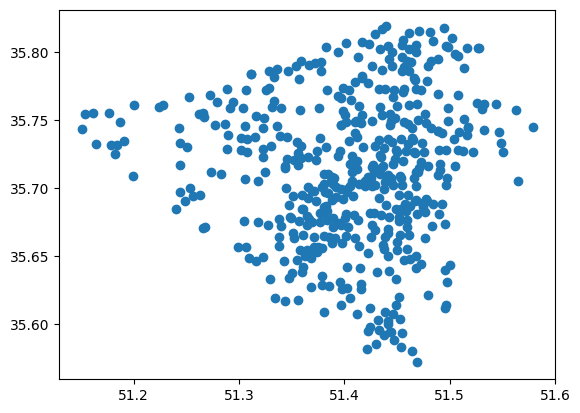

In [6]:
plt.scatter(df_filtered['longitude'], df_filtered['latitude'])
plt.show()

In [68]:
# Define median longitude & latitude
lon_median = df_filtered['longitude'].median()
lat_median = df_filtered['latitude'].median()

# Assign quadrants
df_filtered.loc[:,'quadrant'] = df_filtered.apply(
    lambda row: (
        "Q1" if (row['longitude'] >= lon_median and row['latitude'] >= lat_median) else
        "Q2" if (row['longitude'] < lon_median and row['latitude'] >= lat_median) else
        "Q3" if (row['longitude'] < lon_median and row['latitude'] < lat_median) else
        "Q4"
    ), axis=1
)

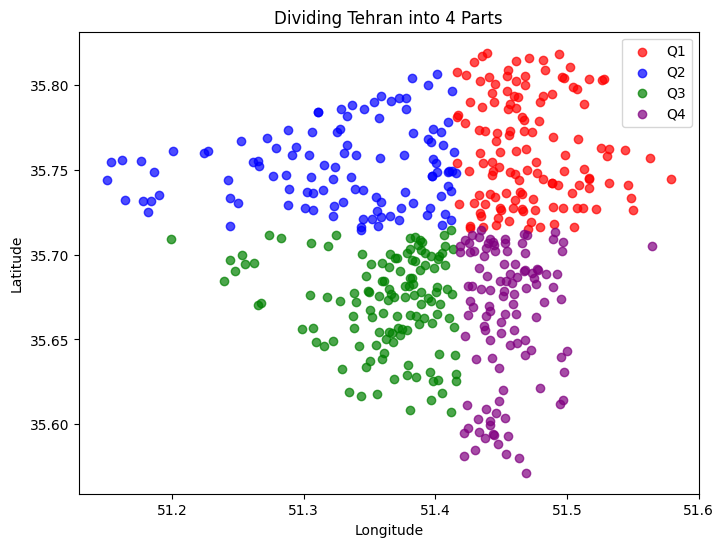

In [69]:
import matplotlib.pyplot as plt

# Plot each quadrant in a different color
plt.figure(figsize=(8, 6))
for q, color in zip(["Q1", "Q2", "Q3", "Q4"], ['red', 'blue', 'green', 'purple']):
    subset = df_filtered[df_filtered['quadrant'] == q]
    plt.scatter(subset['longitude'], subset['latitude'], label=q, color=color, alpha=0.7)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Dividing Tehran into 4 Parts")
plt.legend()
plt.show()

In [70]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Extract coordinates
coords = np.array(list(zip(df_filtered['longitude'], df_filtered['latitude'])))

# Normalize using StandardScaler
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

# Now use coords_scaled for clustering

In [71]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
coords_scaled = scaler.fit_transform(coords)


In [72]:
coords_scaled = coords_scaled[~np.isnan(coords_scaled).any(axis=1)]


In [73]:
print(np.isnan(coords_scaled).sum())
print("Shape of coords_scaled:", coords_scaled.shape)
print("Shape of df_filtered:", df_filtered.shape)

0
Shape of coords_scaled: (479, 2)
Shape of df_filtered: (479, 4)


In [74]:
# Create a boolean mask for rows without NaN values
nan_mask = ~np.isnan(coords_scaled).any(axis=1)
print("Number of valid rows:", nan_mask.sum())

Number of valid rows: 479


In [14]:
# Drop rows with NaN values in coords_scaled
coords_scaled = coords_scaled[nan_mask]

# Drop the same rows in df_filtered
df_filtered = df_filtered[nan_mask]

In [15]:
nan_mask = ~np.isnan(coords_scaled).any(axis=1)


In [16]:
# Drop rows with NaN values in coords_scaled
coords_scaled = coords_scaled[nan_mask]

# Drop the same rows in df_filtered
df_filtered = df_filtered[nan_mask]

In [75]:
print(db.labels_)  # Check cluster labels output
print(len(db.labels_), len(df_filtered))  # Compare lengths


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
479 479


In [76]:
print(coords_scaled.shape)  # Should be (num_points, 2)
print(coords_scaled[:5])    # Print first 5 rows


(479, 2)
[[0.65126067 0.97737911]
 [0.74810379 0.98762977]
 [0.72584668 0.97926492]
 [0.62065802 0.95381834]
 [0.61205487 0.90833553]]


In [19]:
type(df_filtered)


pandas.core.frame.DataFrame

In [77]:
df_filtered = pd.DataFrame(df_filtered, columns=['longitude', 'latitude'])
df_filtered['cluster'] = db.labels_


In [78]:
print(type(df_filtered))  # Should print <class 'pandas.core.frame.DataFrame'>
print(df_filtered.head())  # See first few rows


<class 'pandas.core.frame.DataFrame'>
   longitude   latitude  cluster
0  51.429482  35.813517        0
1  51.470947  35.816056        0
2  51.461417  35.813984        0
3  51.416379  35.807681        0
4  51.412695  35.796416        0


In [204]:
from sklearn.cluster import DBSCAN

# Run DBSCAN on normalized data
db = DBSCAN(eps=0.001, min_samples=1).fit(coords_scaled)

# Assign cluster labels
df_filtered['cluster'] = db.labels_

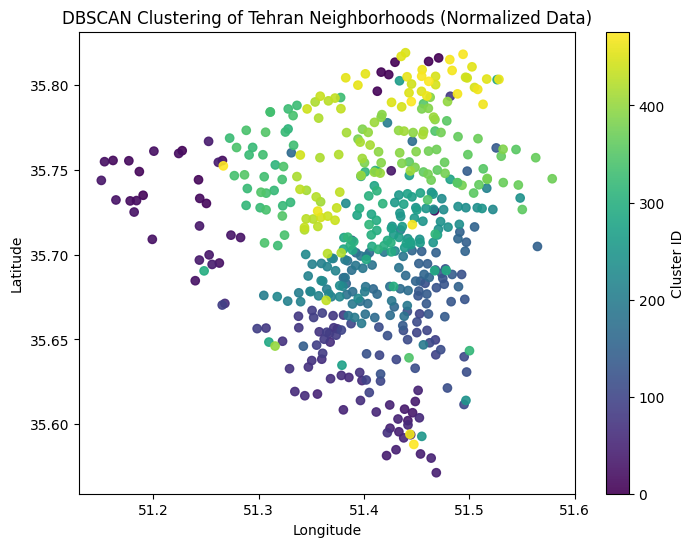

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(df_filtered['longitude'], df_filtered['latitude'], c=df_filtered['cluster'], cmap='viridis', alpha=0.9)
plt.colorbar(label="Cluster ID")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("DBSCAN Clustering of Tehran Neighborhoods (Normalized Data)")
plt.show()


In [81]:
print(df_region.head())

   id            name   latitude  longitude
0   1           دربند  35.813517  51.429482
1   2         نیاوران  35.816056  51.470947
2   3  جمشیدیه-جماران  35.813984  51.461417
3   4        زعفرانیه  35.807681  51.416379
4   5         محمودیه  35.796416  51.412695


In [82]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt


In [83]:
# Create Point objects from lat/long
geometry = [Point(lon, lat) for lon, lat in zip(df_region['longitude'], df_region['latitude'])]


In [84]:
gdf = gpd.GeoDataFrame(df_region, geometry=geometry, crs="EPSG:4326")  # WGS84 coordinate system
print("\nGeoDataFrame:")
print(gdf.head())


GeoDataFrame:
   id            name   latitude  longitude                   geometry
0   1           دربند  35.813517  51.429482  POINT (51.42948 35.81352)
1   2         نیاوران  35.816056  51.470947  POINT (51.47095 35.81606)
2   3  جمشیدیه-جماران  35.813984  51.461417  POINT (51.46142 35.81398)
3   4        زعفرانیه  35.807681  51.416379  POINT (51.41638 35.80768)
4   5         محمودیه  35.796416  51.412695   POINT (51.4127 35.79642)


In [85]:
print(gdf[gdf['buffer'].is_empty])
print(gdf[gdf['buffer'].isna()])
print(gdf['buffer'].apply(lambda x: isinstance(x, Polygon)).all())


KeyError: 'buffer'

In [31]:
print(df_region.columns)

Index(['id', 'name', 'latitude', 'longitude'], dtype='object')


In [87]:
gdf = gpd.GeoDataFrame(df_region, geometry=geometry, crs="EPSG:4326")
# Convert to a projected CRS (meters) for accurate buffering
gdf = gdf.to_crs("EPSG:2059")  # Web Mercator
gdf['buffer'] = gdf.geometry.buffer(1000)  # 1 km buffer

In [88]:
print(gdf.head())


   id            name   latitude  longitude                        geometry  \
0   1           دربند  35.813517  51.429482  POINT (538788.521 3963526.468)   
1   2         نیاوران  35.816056  51.470947  POINT (542533.162 3963825.281)   
2   3  جمشیدیه-جماران  35.813984  51.461417  POINT (541673.342 3963591.386)   
3   4        زعفرانیه  35.807681  51.416379  POINT (537607.528 3962874.097)   
4   5         محمودیه  35.796416  51.412695  POINT (537279.984 3961623.184)   

                                              buffer  
0  POLYGON ((539788.521 3963526.468, 539783.706 3...  
1  POLYGON ((543533.162 3963825.281, 543528.347 3...  
2  POLYGON ((542673.342 3963591.386, 542668.527 3...  
3  POLYGON ((538607.528 3962874.097, 538602.713 3...  
4  POLYGON ((538279.984 3961623.184, 538275.169 3...  


In [89]:
# Create a convex hull polygon
convex_hull_polygon = gdf.unary_union.convex_hull

<ipython-input-89-d5be6e2e6e77>:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  convex_hull_polygon = gdf.unary_union.convex_hull


In [90]:
print(gdf['buffer'].head())

0    POLYGON ((539788.521 3963526.468, 539783.706 3...
1    POLYGON ((543533.162 3963825.281, 543528.347 3...
2    POLYGON ((542673.342 3963591.386, 542668.527 3...
3    POLYGON ((538607.528 3962874.097, 538602.713 3...
4    POLYGON ((538279.984 3961623.184, 538275.169 3...
Name: buffer, dtype: geometry


In [36]:
# Check for invalid geometries
print(gdf[gdf['buffer'].is_empty])  # Check for empty geometries
print(gdf[gdf['buffer'].isna()])    # Check for NaN values

Empty GeoDataFrame
Columns: [id, name, latitude, longitude, geometry, buffer]
Index: []
Empty GeoDataFrame
Columns: [id, name, latitude, longitude, geometry, buffer]
Index: []


In [91]:
# Drop rows with invalid geometries
gdf = gdf[~gdf['buffer'].is_empty & ~gdf['buffer'].isna()]

In [92]:
from shapely.geometry import Polygon

# Check if all geometries are Polygons
print(gdf['buffer'].apply(lambda x: isinstance(x, Polygon)).all())

True


In [94]:
# Recreate buffers
gdf['buffer'] = gdf.geometry.buffer(1000)  # 1000 meters = 1 km

POLYGON ((542460.7209066319 3936692.515425305, 538176.8839864086 3937792.7192385285, 530273.1759620394 3941952.9628320383, 517994.3021736691 3951875.2633952904, 514867.45761829667 3954444.387081172, 513609.047953283 3955722.4373458494, 513882.86845264595 3956946.663032498, 539689.1406091327 3964151.916682497, 544626.0227289968 3964073.4664432183, 547713.2377332802 3962449.3950067055, 552323.143444263 3955973.644057661, 551078.5830844255 3951537.9145561634, 542460.7209066319 3936692.515425305))


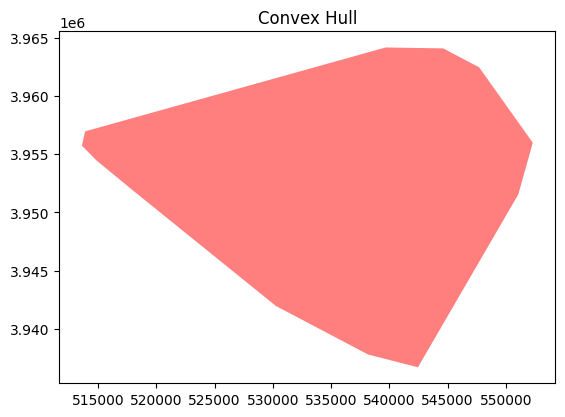

In [95]:
# Check convex_hull_polygon
print(convex_hull_polygon)

# Plot convex hull
gpd.GeoSeries([convex_hull_polygon]).plot(alpha=0.5, color='red')
plt.title("Convex Hull")
plt.show()

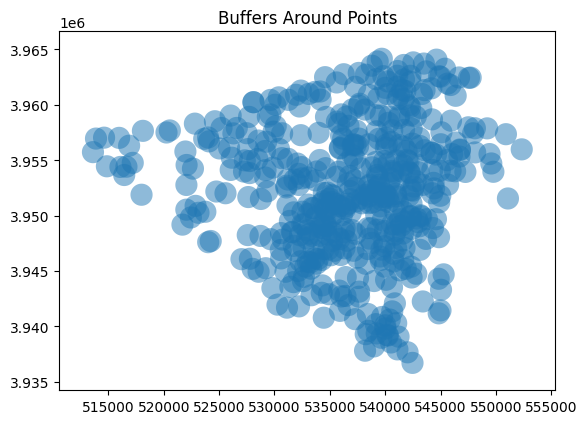

In [96]:
# Set the buffer column as the active geometry
gdf.set_geometry('buffer', inplace=True)

# Plot the buffers (no need for `column='buffer'`)
gdf.plot(alpha=0.5, legend=True)
plt.title("Buffers Around Points")
plt.show()

# Reset geometry to original points (optional)
gdf.set_geometry('geometry', inplace=True)

<Axes: >

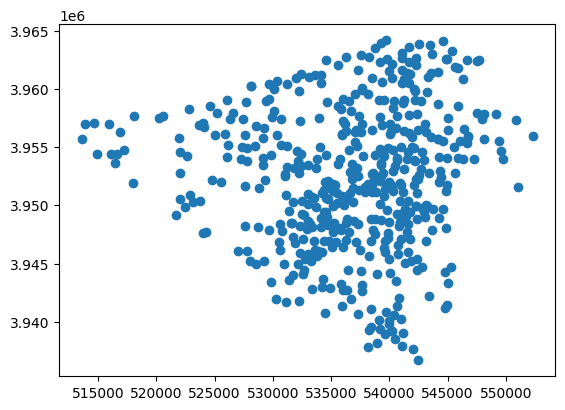

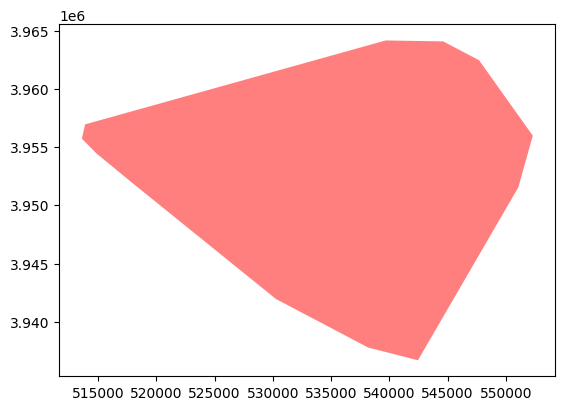

In [97]:
gdf.plot()
gpd.GeoSeries([convex_hull_polygon]).plot(alpha=0.5, color='red')


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

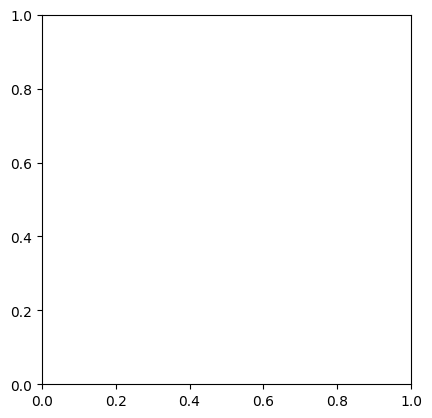

In [99]:
gdf = gdf.to_crs("EPSG:2059")  # Web Mercator
gdf['buffer'] = gdf.geometry.buffer(1000)  # 1000 meters = 1 km
gdf.plot(column='buffer', alpha=0.5)
gpd.GeoSeries([convex_hull_polygon]).plot(alpha=0.5, color='red')


In [101]:
from sklearn.cluster import KMeans

# Cluster points into groups
kmeans = KMeans(n_clusters=5)
df['cluster'] = kmeans.fit_predict(df[['latitude', 'longitude']])

# Create convex hull polygons for clusters
clusters = gdf.dissolve(by='cluster').convex_hull

NameError: name 'df' is not defined

In [102]:
# Load a polygon shapefile (e.g., Tehran neighborhoods)
neighborhoods = gpd.read_file("tehran_neighborhoods.shp")

# Spatial join: Match points to polygons
gdf = gpd.sjoin(gdf, neighborhoods, how='left', op='within')

DataSourceError: tehran_neighborhoods.shp: No such file or directory

In [46]:
from sklearn.cluster import DBSCAN
import geopandas as gpd
from shapely.geometry import Point
#gdf = gpd.GeoDataFrame(df_region, geometry=geometry, crs="EPSG:4326")
# Convert to a projected CRS (meters) for accurate buffering
gdf = gdf.to_crs("EPSG:32639")  # Web Mercator
print(gdf)

      id            name   latitude  longitude  \
0      1           دربند  35.813517  51.429482   
1      2         نیاوران  35.816056  51.470947   
2      3  جمشیدیه-جماران  35.813984  51.461417   
3      4        زعفرانیه  35.807681  51.416379   
4      5         محمودیه  35.796416  51.412695   
..   ...             ...        ...        ...   
474  475         فرمانیه  35.805258  51.454840   
475  476        کامرانیه  35.802239  51.461555   
476  477          قیطریه  35.790305  51.444977   
477  479         محله ما  35.588128  51.447368   
478  480           گلدشت  35.752387  51.266495   

                           geometry  \
0    POINT (538799.233 3963350.187)   
1    POINT (542543.854 3963649.018)   
2     POINT (541684.039 3963415.12)   
3     POINT (537618.25 3962697.814)   
4    POINT (537290.714 3961446.905)   
..                              ...   
474  POINT (541094.316 3962444.456)   
475  POINT (541702.612 3962112.477)   
476  POINT (540210.729 3960781.943)   
477  POIN

In [190]:
from sklearn.preprocessing import StandardScaler
import numpy as np
# Extract X and Y coordinates from GeoDataFrame
coords_proj = np.array([(geom.x, geom.y) for geom in gdf.geometry])
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords_proj)
db = DBSCAN(eps=1, min_samples=3).fit(coords_scaled)  # Adjust `eps` after normalizing

gdf['cluster'] = db.labels_


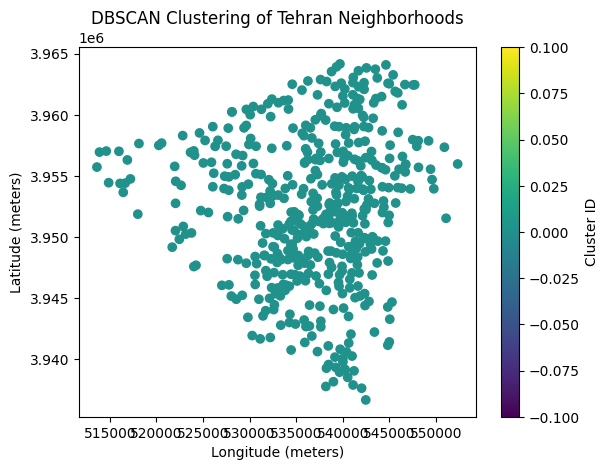

In [191]:
import matplotlib.pyplot as plt
plt.scatter(coords_proj[:, 0], coords_proj[:, 1], c=gdf['cluster'], cmap='viridis')
plt.colorbar(label="Cluster ID")
plt.xlabel("Longitude (meters)")
plt.ylabel("Latitude (meters)")
plt.title("DBSCAN Clustering of Tehran Neighborhoods")
plt.show()

In [206]:
coords_proj = np.array([(geom.x, geom.y) for geom in gdf.geometry])
db = DBSCAN(eps=0.2, min_samples=5).fit(coords_proj)  # eps=500 meters
gdf['cluster'] = db.labels_

print(gdf[['geometry', 'cluster']])

                           geometry  cluster
0    POINT (538788.521 3963526.469)       -1
1    POINT (542533.162 3963825.282)       -1
2    POINT (541673.342 3963591.387)       -1
3    POINT (537607.528 3962874.098)       -1
4    POINT (537279.984 3961623.185)       -1
..                              ...      ...
474  POINT (541083.611 3962620.721)       -1
475  POINT (541691.908 3962288.737)       -1
476   POINT (540200.01 3960958.204)       -1
477  POINT (540518.166 3938535.648)       -1
478  POINT (524082.672 3956694.136)       -1

[479 rows x 2 columns]


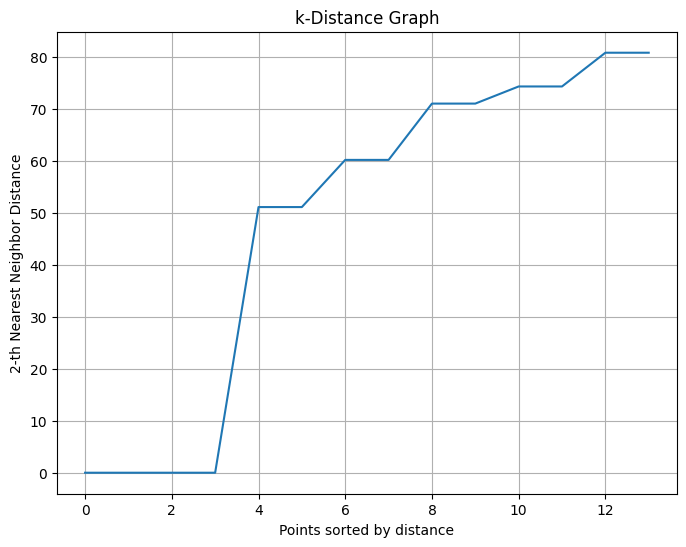

                           geometry  cluster
0    POINT (538788.521 3963526.469)       -1
1    POINT (542533.162 3963825.282)       -1
2    POINT (541673.342 3963591.387)       -1
3    POINT (537607.528 3962874.098)       -1
4    POINT (537279.984 3961623.185)       -1
..                              ...      ...
474  POINT (541083.611 3962620.721)       -1
475  POINT (541691.908 3962288.737)       -1
476   POINT (540200.01 3960958.204)       -1
477  POINT (540518.166 3938535.648)       -1
478  POINT (524082.672 3956694.136)       -1

[479 rows x 2 columns]


In [207]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

# Example data (replace with your actual data)
coords_proj = np.array([(geom.x, geom.y) for geom in gdf.geometry])

# Step 1: Compute the k-distance
min_samples = 2  # Set this to your desired min_samples value
k = min_samples

# Use NearestNeighbors to find the k-th nearest neighbor distances
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(coords_proj)
distances, indices = neighbors_fit.kneighbors(coords_proj)

# Sort the k-th nearest neighbor distances
k_distances = distances[:, -1]  # Take the distance to the k-th neighbor
k_distances_sorted = np.sort(k_distances)
mask = (k_distances >= 0) & (k_distances <= 100)
k_distances_filtered = k_distances[mask]
k_distances_sorted = np.sort(k_distances_filtered)

# Step 2: Plot the k-distance graph
plt.figure(figsize=(8, 6))
plt.plot(k_distances_sorted)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}-th Nearest Neighbor Distance')
plt.title('k-Distance Graph')
plt.grid()
plt.show()

# Step 3: Choose eps from the elbow in the graph
eps =0.2  # Replace this with the value you identify from the graph

# Step 4: Run DBSCAN with the chosen eps
db = DBSCAN(eps=eps, min_samples=min_samples).fit(coords_proj)
gdf['cluster'] = db.labels_

# Print the results
print(gdf[['geometry', 'cluster']])

In [232]:
db = DBSCAN(eps=.05, min_samples=5, metric='haversine').fit(np.radians(coords_proj))
labels = db.labels_


In [233]:
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters)

3


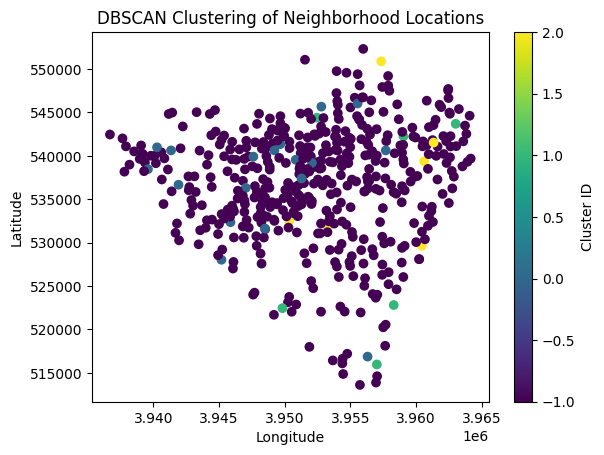

In [235]:
plt.scatter(coords_proj[:, 1], coords_proj[:, 0], c=labels, cmap='viridis', label="Clustered Points")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("DBSCAN Clustering of Neighborhood Locations")
plt.colorbar(label="Cluster ID")
plt.show()